# Sprint
## 機械学習スクラッチ クラスタリング
スクラッチでK-meansを実装した後、それを使用しクラスタ分析を行います。

K-meansのクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


以下に雛形を用意してあります。このScratchKMeansクラスにコードを書き加えていってください。

In [1]:
import numpy as np
import time
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    
    Attributes
    ----------
    self.mu : ndarray(n_clusters, n_features)
      クラスタの中心点
    self.r_binary : ndarray(n_samples, n_clusters)
      サンプル毎の所属クラスタをone-hot表現で表した配列
    self.sse : [float]
      クラスタ内誤差平方和（SSE）の推移
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
    
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        # preparing
        n_samples = X.shape[0]
        self.mu = None
        self.r_binary = None
        self.sse = [-1]

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('start learning')
        
        start_time = time.time()

        # learning
        for j in range(self.n_init):
            tmp_mu = X[np.random.choice(n_samples, self.n_clusters, replace=False), :]
            tmp_r_binary = None
            tmp_sse = []
            for i in range(self.max_iter):
                # break flag
                _break = False
                
                # assign cluster
                tmp_r_binary = self._assign_cluster(X, tmp_mu)

                # diff old mu /new mu
                _mu_new = self._move_mu(X, tmp_r_binary)
                _diff = np.sqrt(self._each_diff_norm_squared(_mu_new, tmp_mu))
                
                # 微小な負数の平方根を計算しようとしてnanが出ることがあるので回避
                _diff_sum = np.nansum(np.diag(_diff))
                if _diff_sum < self.tol:
                    _break = True
                tmp_mu = _mu_new

                # calc new sse
                tmp_sse.append(self._calc_SSE(X, tmp_r_binary, tmp_mu))
                if self.verbose:
                    print(f'{j+1},{i+1} SSE: {tmp_sse[-1]}')

                if _break: break
            # update mu / r_binary / sse
            if (tmp_sse[-1] < self.sse[-1]) or (self.sse[-1] < 0):
                self.mu = tmp_mu
                self.r_binary = tmp_r_binary
                self.sse = tmp_sse
        
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'Done! elapsed time: {elapsed_time:.5f}s')
    
    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        Return
        ----------
          ndarray(n_samples, )
            所属クラスタをrange(0, n_clusters)で表現した一次元配列
        """
        # assign cluster
        _r_binary = self._assign_cluster(X, self.mu)

        # make output data
        cluster_num = np.full(X.shape[0], -1)
        for c in range(self.n_clusters):
            cluster_num[np.nonzero(_r_binary[:, c])] = c

        return cluster_num

    def _each_diff_norm_squared(self, A, B):
        """
        行列A,Bから一行ずつ選び出し、その差のベクトルのノルムの二乗||(A_i)-(B_j)||^2を計算する

        Parameters
        ----------
        A, B : ndarray
            行列 1行が一つのベクトルに対応している
        Return
        ----------
          ndarray(A.shape[0], B.shape(0))
        """
        A_norm = np.linalg.norm(A, axis=1)

        B_norm = np.linalg.norm(B, axis=1)

        A_dot_B = A@B.T

        norm_squared = A_norm.reshape(-1, 1)**2 + B_norm**2 - 2*A_dot_B

        return norm_squared

    def _calc_SSE(self, X, r_binary, mu):
        """ 
        クラスタ内誤差平方和を計算する。

        """
        # calc sse
        _sse = np.sum(r_binary * self._each_diff_norm_squared(X, mu))

        return _sse

    def _assign_cluster(self, X, mu):
        """
        データ点をもっとも近い中心点が属するクラスタに割り当てる
        """
        # calc norm
        _each_diff_norm = self._each_diff_norm_squared(X, mu)

        # one-hot
        _r_binary = np.zeros((X.shape[0], self.n_clusters))
        _r_binary[range(_r_binary.shape[0]), np.argmin(_each_diff_norm, axis=1)] = 1

        return _r_binary

    def _move_mu(self, X, r_binary):
        """
        クラスタの中心点の位置をクラスタの重心まで移動する
        """
        mu_new = np.zeros((self.n_clusters, X.shape[1]))

        for k in range(self.n_clusters):
            mask = np.nonzero(r_binary[:, k])
            mu_new[k] = np.mean(X[mask], axis=0)
        
        return mu_new

## クラスタリングのための人工データセット
クラスタリングを実験するための人工データセットを作成するコードを用意しています。


この`make_blobs`関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 \_（アンダースコア） で受け取っています。


**《シンプルデータセット3》**

In [2]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)
print(X)

[[ 0.72086751  3.71347124]
 [-1.89468423  7.96898545]
 [ 1.35678894  4.36462484]
 [ 1.05374379  4.49286859]
 [ 1.59141542  4.90497725]
 [ 0.78260667  4.15263595]
 [-1.95751686  3.87291474]
 [-0.77354537  7.87923564]
 [ 0.12313498  5.27917503]
 [-1.43284669  7.71577043]
 [-0.92819001  7.02698199]
 [-1.74836345  7.06307447]
 [-1.26789718  7.25141327]
 [-0.98661744  7.74968685]
 [-0.81984047  7.50994722]
 [ 2.99684287  0.22378413]
 [ 1.46870582  1.86947425]
 [-0.33533163  3.390122  ]
 [-1.86407034  2.93379754]
 [ 2.62496786  0.28025075]
 [ 2.11114739  3.57660449]
 [-1.8219901   7.61654999]
 [-1.91186205  3.18750686]
 [ 2.28809874  0.12954182]
 [ 0.5285368   4.49723858]
 [-1.57613028  2.58614312]
 [-0.565433    3.65813966]
 [ 0.802314    4.38196181]
 [ 2.79939362  1.84560825]
 [ 2.64465731  0.80770124]
 [ 1.7190373   0.71788708]
 [-0.93564005  7.03443119]
 [ 2.14398059  0.69677319]
 [ 2.06051753  1.79059891]
 [-1.21986433  3.3789856 ]
 [ 1.13280393  3.87673946]
 [-1.497272    8.80022604]
 

# 【問題1】
## 中心点の初期値を決める
入力されたデータから$K$個の中心点$μ_1$から$μ_K$の初期値を決めるコードを作成してください。$K$は指定したクラスタ数です。


最もシンプルな初期値の決定方法は、データ点$X_n$の中からランダムに$K$個選ぶことです。今回はこれを実装してください。


K-meansの学習結果は中心点$μ$の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

```python
n_samples = X.shape[0]
self.mu = X[np.random.randint(0, n_samples, self.n_clusters), :]
```

# 【問題2】
## SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。


K-meansはこのSSEを最小化する$r_{nk}$と$\mu_k$を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。

$$
SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2
$$

$n$ : データ点のインデックス


$k$ : クラスタのインデックス


$X_n$ : $n$番目のデータ点


$\mu_k$ : $k$番目の中心点


$r_{nk}$ : データ点$X_n$がクラスタ$k$に所属していたら1、そうでなければ0

以下の式から計算する。
$$
\|A-B\|^2 = \|A\|^2 + \|B\|^2 - 2*(A \cdot B)
$$
-> `_each_diff_norm_squared(A, B)`
```python
    def _each_diff_norm_squared(self, A, B):
        """
        行列A,Bから一行ずつ選び出し、その差のベクトルのノルムの二乗||(A_i)-(B_j)||^2を計算する

        Parameters
        ----------
        A, B : ndarray
            行列 1行が一つのベクトルに対応している
        Return
        ----------
          ndarray(A.shape[0], B.shape(0))
        """
        A_norm = np.linalg.norm(A, axis=1)

        B_norm = np.linalg.norm(B, axis=1)

        A_dot_B = A@B.T

        norm_squared = A_norm.reshape(-1, 1)**2 + B_norm**2 - A_dot_B

        return norm_squared

    def _calc_SSE(self, X):
        """ 
        クラスタ内誤差平方和を計算する。

        """
        # calc sse
        _sse = np.sum(self.r_binary * self._each_diff_norm_squared(X, self.mu))

        return _sse
```

## クラスタの割り当てと中心点の移動を繰り返す
K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。


- 中心点$\mu_k$を固定した上で$SSE$を最小化するクラスタの割り当て$r_{nk}$を選ぶ。
- クラスタの割り当て$r_{nk}$を固定した上で$SSE$を最小化する中心点$\mu_k$を選ぶ。

最初の中心点$\mu_k$は問題1で作成した初期値です。


順番に見ていきます。

# 【問題3】
## クラスタへの割り当て
全てのデータ点$X_n$を最も近い中心点$\mu_k$に割り当てるコードを作成してください。


K-menasにおける**近い**とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル$p, q$に対しては以下の数式で表現できます。

$$
\|q-p\| = \sqrt{(q-p)\cdot(q-p)}
$$

NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。


[numpy.linalg.norm — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html)


中心点$\mu_k$を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

実数空間においては$\|x\|\geq0$であるから、$\|a\|\geq\|b\|$のとき$\|a\|^2\geq\|b\|^2$もまた成り立つ。

よって、簡単のためにユークリッド距離の比較は$\|q-p\|^2$を用いて行う。 -> `_each_diff_norm_squared(A, B)`
```python
    def _assign_cluster(self, X):
        """
        データ点をもっとも近い中心点が属するクラスタに割り当てる
        """
        # calc norm
        _each_diff_norm = self._each_diff_norm_squared(X, self.mu)

        # one-hot
        _r_binary = np.zeros((X.shape[0], self.n_clusters))
        _r_binary[range(_r_binary.shape[0]), np.argmin(_each_diff_norm, axis=1)] = 1

        return _r_binary
```

# 【問題4】
## 中心点の移動
中心点$\mu_k$を$k$番目のクラスタに割り当てられる全てのデータ点$X_n$の平均値（重心）に移動するコードを作成してください。


クラスタの割り当て$r_{nk}$を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

```python
    def _move_mu(self, X):
        """
        クラスタの中心点の位置をクラスタの重心まで移動する
        """
        mu_new = np.zeros((self.n_clusters, X.shape[1]))

        for k in range(self.n_clusters):
            mask = np.nonzero(self.r_binary[:, k])
            mu_new[k] = np.mean(X[mask], axis=0)
        
        return mu_new
```

# 【問題5】
## 繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。


次のどれかの条件を満たしたらこれを止めます。


- 繰り返しが指定した回数に到達する。（雛形では引数max_iter）
- 中心点$\mu_k$と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）


# 【問題6】
## 異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。


複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点$\mu_k$を保持しておきます。

以下コードは問題5, 6に対応
```python
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        # preparing
        n_samples = X.shape[0]
        self.mu = None
        self.r_binary = None
        self.sse = [-1]

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('start learning')
        
        start_time = time.time()

        # learning
        for j in range(self.n_init):
            tmp_mu = X[np.random.choice(n_samples, self.n_clusters, replace=False), :]
            tmp_r_binary = None
            tmp_sse = []
            for i in range(self.max_iter):
                # break flag
                _break = False
                
                # assign cluster
                tmp_r_binary = self._assign_cluster(X, tmp_mu)

                # diff old mu /new mu
                _mu_new = self._move_mu(X, tmp_r_binary)
                _diff = np.sqrt(self._each_diff_norm_squared(_mu_new, tmp_mu))
                
                # 微小な負数の平方根を計算しようとしてnanが出ることがあるので回避
                _diff_sum = np.nansum(np.diag(_diff))
                if _diff_sum < self.tol:
                    _break = True
                tmp_mu = _mu_new

                # calc new sse
                tmp_sse.append(self._calc_SSE(X, tmp_r_binary, tmp_mu))
                if self.verbose:
                    print(f'{j+1},{i+1} SSE: {tmp_sse[-1]}')

                if _break: break
            # update mu / r_binary / sse
            if (tmp_sse[-1] < self.sse[-1]) or (self.sse[-1] < 0):
                self.mu = tmp_mu
                self.r_binary = tmp_r_binary
                self.sse = tmp_sse
        
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'Done! elapsed time: {elapsed_time:.5f}s')
```

# 【問題7】
## 推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。


- データ点$X_n$と学習で決まった中心点$\mu_k$に対し、$SSE$を最小化する$r_{nk}$を選ぶ。

具体的には次のことです。


- データ点$X_n$を最も近い$\mu_k$に割り当てる。

```python
    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        Return
        ----------
          ndarray(n_samples, )
            所属クラスタをrange(0, n_clusters)で表現した一次元配列
        """
        # assign cluster
        _r_binary = self._assign_cluster(X, self.mu)

        # make output data
        cluster_num = np.full(X.shape[0], -1)
        for c in range(self.n_clusters):
            cluster_num[np.nonzero(_r_binary[:, c])] = c

        return cluster_num
```

# 【問題8】
## エルボー法の実装
K-meansにおいて中心点の個数$k$は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数$k$を検討するためのコードを作成してください。


SSEを縦軸、クラスタ数$k$を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

-> 問題5, 6で実装済み

実際に学習・予測を行ってみる。

In [3]:
skm = ScratchKMeans(n_clusters=4, n_init=20, max_iter=20, tol=1.0e-6, verbose=True)
skm.fit(X)

start learning
1,1 SSE: 132.99397039922638
1,2 SSE: 132.5005546971779
1,3 SSE: 132.25725378929906
1,4 SSE: 132.25725378929906
2,1 SSE: 256.4882958545686
2,2 SSE: 135.38064448120275
2,3 SSE: 134.68639490748558
2,4 SSE: 134.32814621955902
2,5 SSE: 133.54759268797744
2,6 SSE: 132.674651423462
2,7 SSE: 132.4902159294081
2,8 SSE: 132.22875558038191
2,9 SSE: 132.22875558038191
3,1 SSE: 48.633783207064134
3,2 SSE: 48.633783207064134
4,1 SSE: 210.9100723964366
4,2 SSE: 187.85182418094246
4,3 SSE: 170.86960607102787
4,4 SSE: 72.01423454579098
4,5 SSE: 48.633783207064134
4,6 SSE: 48.633783207064134
5,1 SSE: 199.855220673786
5,2 SSE: 62.7215242593262
5,3 SSE: 48.633783207064134
5,4 SSE: 48.633783207064134
6,1 SSE: 237.14533818354698
6,2 SSE: 192.37932327683143
6,3 SSE: 68.12359493492667
6,4 SSE: 48.633783207064134
6,5 SSE: 48.633783207064134
7,1 SSE: 48.633783207064134
7,2 SSE: 48.633783207064134
8,1 SSE: 671.6712481994234
8,2 SSE: 62.81425155534431
8,3 SSE: 48.633783207064134
8,4 SSE: 48.6337832

In [4]:
print(skm.r_binary)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0.

In [5]:
import matplotlib.pyplot as plt
def plot_cluster(X, model):
    """
    与えられたデータから所属クラスタを予測してプロットする
    """
    _assigned_cluster = model.predict(X)
    _mu = model.mu

    %matplotlib inline
    plt.title('K-means clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    for c in range(model.n_clusters):
        Xc = X[_assigned_cluster == c]
        plt.scatter(Xc[:, 0], Xc[:, 1], label=c)

    plt.scatter(_mu[:, 0], _mu[:, 1], marker='x', label="mu")
    plt.legend()
    plt.show()

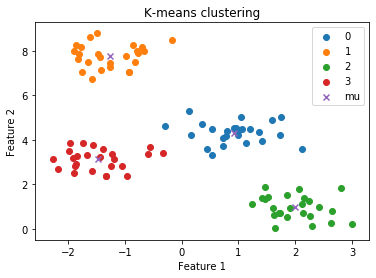

In [6]:
plot_cluster(X, skm)

# 【問題9】
## （アドバンス課題）シルエット図
$k$を決める助けになるものとしてシルエット図もあります。シルエット図を表示するコードを作成してください。


Matplotlibを使い図を表示するコードは用意しました。以下を与えてください。


`silhouette_vals` : shape(n_samples,)のndarray、各データ点のシルエット係数


`silhouette_avg` : float、シルエット係数の平均値


`y_km` : shape(n_samples,)のndarray、各データ点のクラスタラベル名


`cluster_labels` : list、クラスタのラベル名のリスト


`n_clusters` : int、クラスタ数


$n$番目のデータ点に対するシルエット係数$s_n$は以下の数式でを求められます。この数式を実装し、シルエット図を確認してください。

$$
s_n = \frac{b_n-a_n}{max(b_n,a_n)}
$$

$a_n$ : 凝集度。同じクラスタ内の他のデータ点との距離の平均値。


$b_n$ : 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。


乖離度$b$が大きく、凝集度$b$が小さい時が理想的であり、シルエット係数$s$は1に近くなります。

In [7]:
# 《シルエット図を表示するためのコード》
from matplotlib import cm
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

NameError: name 'cluster_labels' is not defined